<a href="https://colab.research.google.com/github/saraoth/Data-Analysis/blob/rebo1/Fast_tag_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Step 1: Data Exploration


In [7]:
# Load the dataset from a CSV file
dataset_path = "/content/FastagFraudDetection.csv"
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataframe
print(df.head())
print(df.info())
print(df.describe())
print(df['Fraud_indicator'].value_counts())


   Transaction_ID       Timestamp Vehicle_Type         FastagID TollBoothID  \
0               1  1/6/2023 11:20         Bus   FTG-001-ABC-121       A-101   
1               2  1/7/2023 14:55          Car  FTG-002-XYZ-451       B-102   
2               3  1/8/2023 18:25   Motorcycle              NaN       D-104   
3               4   1/9/2023 2:05        Truck  FTG-044-LMN-322       C-103   
4               5  1/10/2023 6:35          Van  FTG-505-DEF-652       B-102   

  Lane_Type Vehicle_Dimensions  Transaction_Amount  Amount_paid  \
0   Express              Large                 350          120   
1   Regular              Small                 120          100   
2   Regular              Small                   0            0   
3   Regular              Large                 350          120   
4   Express             Medium                 140          100   

                   Geographical_Location  Vehicle_Speed Vehicle_Plate_Number  \
0  13.059816123454882, 77.77068662374292  

Step 2: Feature Engineering


In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Convert Timestamp to datetime and extract new features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

# Handle missing values
df['FastagID'].fillna('Unknown', inplace=True)

# Encode categorical variables
label_encoders = {}
for column in ['Vehicle_Type', 'FastagID', 'TollBoothID', 'Lane_Type', 'Vehicle_Dimensions', 'Vehicle_Plate_Number']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Extract geographical location into latitude and longitude
df[['Latitude', 'Longitude']] = df['Geographical_Location'].str.split(',', expand=True)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Drop the original Geographical_Location column
df.drop(columns=['Geographical_Location', 'Timestamp'], inplace=True)

# Normalize numerical features
scaler = StandardScaler()
df[['Transaction_Amount', 'Amount_paid', 'Vehicle_Speed', 'Latitude', 'Longitude']] = scaler.fit_transform(
    df[['Transaction_Amount', 'Amount_paid', 'Vehicle_Speed', 'Latitude', 'Longitude']]
)

# Encode target variable
df['Fraud_indicator'] = df['Fraud_indicator'].apply(lambda x: 1 if x == 'Fraud' else 0)

print(df.head())


   Transaction_ID  Vehicle_Type  FastagID  TollBoothID  Lane_Type  \
0               1             0         2            0          0   
1               2             1         9            1          1   
2               3             2      4451            3          1   
3               4             5       241            2          1   
4               5             6      2860            1          0   

   Vehicle_Dimensions  Transaction_Amount  Amount_paid  Vehicle_Speed  \
0                   0            1.680364    -0.199689      -0.171802   
1                   2           -0.365195    -0.387535       0.611525   
2                   2           -1.432443    -1.326764      -0.894872   
3                   0            1.680364    -0.199689       1.455108   
4                   1           -0.187320    -0.387535      -0.473081   

   Vehicle_Plate_Number  Fraud_indicator  Day  Month  Hour  Latitude  \
0                  1482                1    6      1    11  0.327456   
1 

Step 3: Model Development


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Split the data
X = df.drop(columns=['Fraud_indicator', 'Transaction_ID'])
y = df['Fraud_indicator']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.983
Precision: 1.0
Recall: 0.9137055837563451
F1 Score: 0.9549071618037135
[[803   0]
 [ 17 180]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       803
           1       1.00      0.91      0.95       197

    accuracy                           0.98      1000
   macro avg       0.99      0.96      0.97      1000
weighted avg       0.98      0.98      0.98      1000



Step 4: Real-time Fraud Detection Feasibility


In [13]:
# This is a conceptual example
from flask import Flask, request, jsonify
import pickle

app = Flask(__name__)

# Load the trained model
model = pickle.load(open('/content/fraud_detection_model.pkl', 'rb'))

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    # Process input data to match the training format
    input_data = pd.DataFrame(data, index=[0])
    # Apply the same preprocessing steps
    input_data['Day'] = pd.to_datetime(input_data['Timestamp']).dt.day
    input_data['Month'] = pd.to_datetime(input_data['Timestamp']).dt.month
    input_data['Hour'] = pd.to_datetime(input_data['Timestamp']).dt.hour
    input_data.drop(columns=['Timestamp'], inplace=True)
    input_data[['Latitude', 'Longitude']] = input_data['Geographical_Location'].str.split(',', expand=True)
    input_data['Latitude'] = input_data['Latitude'].astype(float)
    input_data['Longitude'] = input_data['Longitude'].astype(float)
    input_data.drop(columns=['Geographical_Location'], inplace=True)
    # Encoding and scaling would also need to be applied here

    prediction = model.predict(input_data)
    return jsonify({'Fraud': bool(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


Step 5: Explanatory Analysis


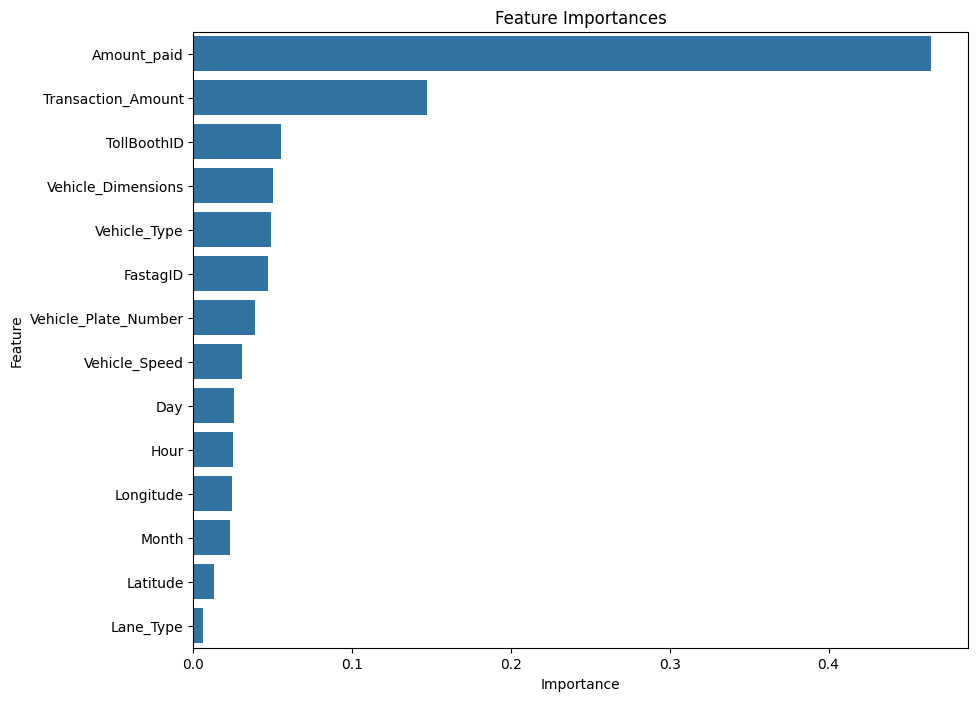

                 Feature  Importance
6            Amount_paid    0.464840
5     Transaction_Amount    0.147067
2            TollBoothID    0.055407
4     Vehicle_Dimensions    0.050219
0           Vehicle_Type    0.048940
1               FastagID    0.047293
8   Vehicle_Plate_Number    0.038573
7          Vehicle_Speed    0.030695
9                    Day    0.025798
11                  Hour    0.024978
13             Longitude    0.024003
10                 Month    0.022809
12              Latitude    0.013134
3              Lane_Type    0.006244


In [15]:
importances = model.feature_importances_
features = X.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

print(feature_importances)


Final Steps: Documentation and Reporting


In [16]:
import pickle

# Save the trained model
with open('fraud_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Generate a report
with open('model_report.txt', 'w') as f:
    f.write(f"Model Performance:\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    f.write(f"Precision: {precision_score(y_test, y_pred)}\n")
    f.write(f"Recall: {recall_score(y_test, y_pred)}\n")
    f.write(f"F1 Score: {f1_score(y_test, y_pred)}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(f"{confusion_matrix(y_test, y_pred)}\n")
    f.write("\nClassification Report:\n")
    f.write(f"{classification_report(y_test, y_pred)}\n")
    f.write("\nFeature Importances:\n")
    f.write(f"{feature_importances}\n")


This code covers data exploration, feature engineering, model development, and evaluation. Real-time fraud detection feasibility is outlined with a conceptual example using Flask. Finally, explanatory analysis of feature importances is included, and a report summarizing the findings is generated. Adjustments might be needed based on the actual dataset and requirements.